In [ ]:
# Notebook is strictly wip at this point, experimenting with the pmdarima pipeline.Pipeline

## FIND THE SOURCE FOR YEO_JOHNSON PLUG THAT IN HERE

In [1]:
#### SOURCE https://alkaline-ml.com/pmdarima/auto_examples/preprocessing/example_date_featurizer.html#sphx-glr-auto-examples-preprocessing-example-date-featurizer-py

import pmdarima as pm
from pmdarima import arima
from pmdarima import model_selection
from pmdarima import pipeline
from pmdarima import preprocessing as ppc

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer


import cabi.etl.load as l
import cabi.etl.transform as t

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

print("pmdarima version: %s" % pm.__version__)



pmdarima version: 1.7.1


In [2]:
col = '2F'

In [3]:
series = l.load_counts(col)

In [4]:
series = t.cumulative_change(series, '6H')

In [5]:
hourly = t.series_to_interval(series, '1H')

In [6]:
hourly = hourly[(hourly.index >= '2020-04-15') & (hourly.index < '2020-06-01')]

In [7]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [ ]:
# Instantiate Powe



preprocessor = ColumnTransformer(
    transformers=[
        
    ])

In [ ]:
%%time

# Load the data and split it into separate pieces
y, X = hourly['2F'], hourly[['time']]
y_train, y_test, X_train, X_test = \
    model_selection.train_test_split(y, X, test_size=48)

# We can examine traits about the time series:
pm.tsdisplay(y_train, lag_max=10)

# We can see the ACF increases and decreases rather rapidly, which means we may
# need some differencing. There also does not appear to be an obvious seasonal
# trend.
n_diffs = arima.ndiffs(y_train, max_d=5)

# Here's what the featurizer will create for us:
date_feat = preprocessing.DateFeaturizer(
    column_name="time",  # the name of the date feature in the exog matrix
    with_day_of_week=True,
    with_day_of_month=False)



_, X_train_feats = date_feat.fit_transform(y_train, X_train)
print("Head of generated exog features:\n%s" % repr(X_train_feats.head()))

# We can plug this exog featurizer into a pipeline:
pipe = pipeline.Pipeline([
    ('date', date_feat),
    ('arima', arima.AutoARIMA(d=n_diffs,
                              trace=3,
                              stepwise=True,
                              suppress_warnings=True,
                              seasonal=True,
                              m=24
                             ))
])

pipe.fit(y_train, X_train)

# Plot our forecasts
forecasts = pipe.predict(exogenous=X_test)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)

n_train = y_train.shape[0]
x = np.arange(n_train + forecasts.shape[0])

ax.plot(x[:n_train], y_train, color='blue', label='Training Data')
ax.plot(x[n_train:], forecasts, color='green', marker='o',
        label='Predicted')
ax.plot(x[n_train:], y_test, color='red', label='Actual')
ax.legend(loc='lower left', borderaxespad=0.5)
ax.set_title('Predicted Foo')
ax.set_ylabel('# Foo')

plt.show()

print(RMSE(y_test, forecasts))

# What next? Try combining different featurizers in your pipeline to enhance
# a model's predictive power.

In [ ]:
print('DONE \n DONE \n DONE \n DONE \n')

## Testing the Fourier Feature

In [ ]:
hourly

In [8]:
%%time


# Load the data and split it into separate pieces
train, test = model_selection.train_test_split(hourly, train_size=672)

lam2 = np.abs(hourly.min()) + 1e-6
# Let's create a pipeline with multiple stages... the Wineind dataset is
# seasonal, so we'll include a FourierFeaturizer so we can fit it without
# seasonality
pipe = pipeline.Pipeline([
    ("boxcox", ppc.BoxCoxEndogTransformer(lmbda2=lam2)),
    ("fourier", ppc.FourierFeaturizer(m=12, k=4)), #attempt to capture 12 hour periods in the day
    ("arima", arima.AutoARIMA(stepwise=True, trace=3, error_action="ignore",
                              seasonal=True,
                              m=24,
                              D=1,
                              nfits=2,
                              disp=True,
                              suppress_warnings=True))
])

pipe.fit(train)
print("Model fit:")
print(pipe)

# We can compute predictions the same way we would on a normal ARIMA object:
preds, conf_int = pipe.predict(n_periods=168, return_conf_int=True)
print("\nForecasts:")
print(preds)

print(f'RMSE: {RMSE(test[:168],preds)}')

print(pipe.summary())

# pipe.plot_diagnostics()

fig, ax = plt.subplots(figsize=(12,8))

x = np.arange(test[:168].shape[0])
ax.plot(x, test[:168], marker='x')
ax.plot(x, preds, marker='o')
ax.set_title('Predicted Values vs. Test Set, One Week Forecast, Fourier and Box-Cox Transformes Applied')



Performing stepwise search to minimize aic
Near non-invertible roots for order (2, 0, 2)(1, 1, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
 ARIMA(2,0,2)(1,1,1)[24] intercept   : AIC=inf, Time=22.48 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=2273.845, Time=0.23 sec
First viable model found (2273.845)
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=1363.278, Time=4.63 sec
New best model found (1363.278 < 2273.845)
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=14.98 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=2271.920, Time=0.85 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=1546.218, Time=0.92 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=1327.325, Time=12.47 sec
New best model found (1327.325 < 1363.278)
Near non-invertible roots for order (1, 0, 0)(2, 1, 1, 

AttributeError: 'Pipeline' object has no attribute 'plot_diagnostics'

## 

In [9]:
%%time


# Load the data and split it into separate pieces
train, test = model_selection.train_test_split(hourly, train_size=672)

lam2 = np.abs(hourly.min()) + 1e-6
# Let's create a pipeline with multiple stages... the Wineind dataset is
# seasonal, so we'll include a FourierFeaturizer so we can fit it without
# seasonality
pipe = pipeline.Pipeline([
    ("boxcox", ppc.BoxCoxEndogTransformer(lmbda2=lam2)),
    ("fourier", ppc.FourierFeaturizer(m=12, k=4)), #attempt to capture 12 hour periods in the day
    ("arima", arima.AutoARIMA(stepwise=True, trace=3, error_action="ignore",
                              seasonal=True,
                              m=24,
                              D=1,
                              nfits=2,
                              disp=True,
                              suppress_warnings=True))
])

pipe.fit(train)
print("Model fit:")
print(pipe)

# We can compute predictions the same way we would on a normal ARIMA object:
preds, conf_int = pipe.predict(n_periods=168, return_conf_int=True)
print("\nForecasts:")
print(preds)

print(f'RMSE: {RMSE(test[:168],preds)}')
print(f'RMSE 24 Hours: {RMSE(test[:168][:24], preds[:24])})

print(pipe.summary())

# pipe.plot_diagnostics()

fig, ax = plt.subplots(figsize=(12,8))

x = np.arange(test[:168].shape[0])
ax.plot(x, test[:168], marker='x')
ax.plot(x, preds, marker='o')
ax.set_title('Predicted Values vs. Test Set, One Week Forecast, Fourier and Box-Cox Transformes Applied')



42.000001

RMSE: 8.446309415011395
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  672
Model:             SARIMAX(5, 0, 0)x(2, 1, 0, 24)   Log Likelihood                -612.710
Date:                            Sat, 05 Sep 2020   AIC                           1257.420
Time:                                    14:01:41   BIC                           1329.002
Sample:                                         0   HQIC                          1285.189
                                            - 672                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
FOURIER_S12-0  1.293e+04   1.23e+05      0.106      0.916   -2.27e+05    2.53e+05
FO

Text(0.5, 1.0, 'Predicted Values vs. Test Set, One Week Forecast, Fourier and Box-Cox Transformes Applied')

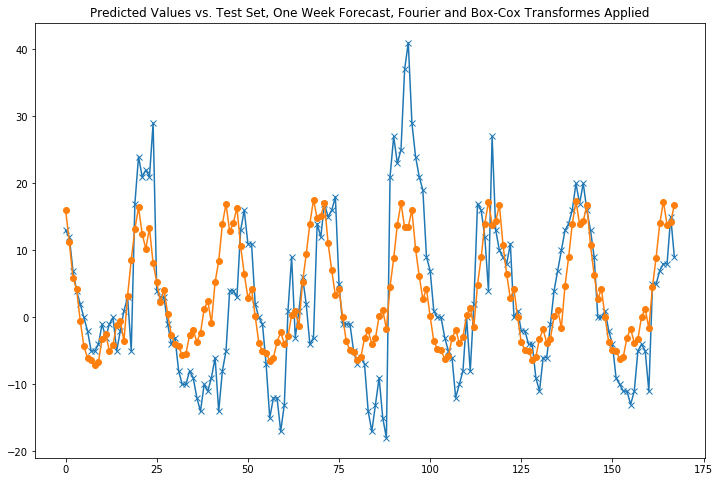

In [10]:
print(f'RMSE: {RMSE(test[:168],preds)}')

print(pipe.summary())

# pipe.plot_diagnostics()

fig, ax = plt.subplots(figsize=(12,8))

x = np.arange(test[:168].shape[0])
ax.plot(x, test[:168], marker='x')
ax.plot(x, preds, marker='o')
ax.set_title('Predicted Values vs. Test Set, One Week Forecast, Fourier and Box-Cox Transformes Applied')

In [12]:
print(f'RMSE 24 Hours: {RMSE(test[:168][:24], preds[:24])}')


RMSE 24 Hours: 5.277358272061359


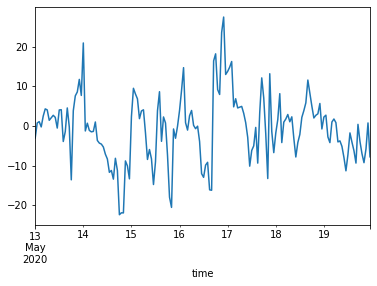

In [14]:
resid = test[:168] - preds
resid.plot()

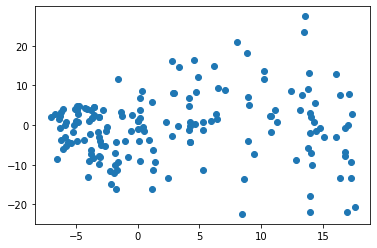

In [16]:
plt.scatter(x=preds, y=resid)

## Cross Validation Approach

### Because the Computation Time on these models is Extreme, We First Try SlidingWindowForecastCV

- If we are able to obtain good results this would be preferable method since it validates the same period length accross different windows in the data set

- The documentation states this well: "This approach to CV slides a window over the training samples while using several future samples as a test set. While similar to the RollingForecastCV, it differs in that the train set does not grow, but rather shifts." For those familiar with sklearn's TimeSeriesSplit, RollingWindowCV is essentially the same approach. Both TimeSeriesSplit and RollingWindowCV validate on a progressively larger portion of the data, with the test set being added to the next fold's trainset and the test window being shifted into the future accordingly.

- We validate in this manner on timeseries data, because the approach is dependent on the time-order of the observations, and so shuffling is not possible as it is under normal CV procedures.

In [17]:
from pmdarima.model_selection import RollingForecastCV

In [18]:
from pmdarima.metrics import smape

In [19]:
smape(test[:168][:24], preds[:24])

83.29270326557422

In [23]:
def SMAPE(y_true, y_pred):
    """Wrapper aroumd smape from pmdarima.metrics
    Returns value of smape on a 0-100% scale 
    instead of 0-200% for interpretability see
    https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
    and https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.metrics.smape.html#pmdarima.metrics.smape
    for reference"""
    return smape(y_true, y_pred) / 2


In [21]:
pipe

Pipeline(steps=[('boxcox',
                 BoxCoxEndogTransformer(floor=1e-16, lmbda=None,
                                        lmbda2=42.000001, neg_action='raise')),
                ('fourier', FourierFeaturizer(k=4, m=12, prefix=None)),
                ('arima',
                 AutoARIMA(D=1, alpha=0.05, d=None, error_action='ignore',
                           information_criterion='aic', m=24, max_D=1, max_P=2,
                           max_Q=2, max_d=2, max_order=5, max_p=5, max_q=5,
                           maxiter=50, method='lbfgs', n_fits=10, n_jobs=1,
                           offset_test_args=None, out_of_sample_size=0,
                           random=False, random_state=None, scoring='mse',
                           scoring_args=None, seasonal=True,
                           seasonal_test='ocsb', seasonal_test_args=None,
                           start_P=1, start_Q=1, start_p=2, start_params=None, ...))])

In [22]:
%%time


# Load the data and split it into separate pieces
train, test = model_selection.train_test_split(hourly, train_size=672)

lam2 = np.abs(hourly.min()) + 1e-6
# Let's create a pipeline with multiple stages... the Wineind dataset is
# seasonal, so we'll include a FourierFeaturizer so we can fit it without
# seasonality
pipe2 = pipeline.Pipeline([
    ("boxcox", ppc.BoxCoxEndogTransformer(lmbda2=lam2)),
    ("fourier", ppc.FourierFeaturizer(m=12, k=4)), #attempt to capture 12 hour periods in the day
    ("arima", arima.AutoARIMA(stepwise=True, trace=3, error_action="ignore",
                              seasonal=True,
                              m=24,
                              D=1,
                              n_fits=4,
                              max_p=7,
                              max_P=3,
                              start_p=5,
                              start_P=2,
                              disp=True,
                              suppress_warnings=True))
])

pipe2.fit(train)
print("Model fit:")
print(pipe2)

# We can compute predictions the same way we would on a normal ARIMA object:
preds, conf_int = pipe2.predict(n_periods=168, return_conf_int=True)
print("\nForecasts:")
print(preds)

print(f'RMSE: {RMSE(test[:168],preds)}')
print(f'RMSE 24 Hours: {RMSE(test[:168][:24], preds[:24])}')
print(f'SMAPE: {SMAPE(test[:168], preds)}')
print(f'SMAPE 24 hours: {SMAPE(test[:168][:24], preds[:24])}')
      

print(pipe2.summary())

# pipe.plot_diagnostics()

fig, ax = plt.subplots(figsize=(12,8))

x = np.arange(test[:168].shape[0])
ax.plot(x, test[:168], marker='x')
ax.plot(x, preds, marker='o')
ax.set_title('Predicted Values vs. Test Set, One Week Forecast, Fourier and Box-Cox Transformes Applied')



Performing stepwise search to minimize aic
Near non-invertible roots for order (5, 0, 2)(2, 1, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
 ARIMA(5,0,2)(2,1,1)[24] intercept   : AIC=inf, Time=64.88 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=2273.845, Time=0.22 sec
First viable model found (2273.845)
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=1363.278, Time=4.86 sec
New best model found (1363.278 < 2273.845)
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=14.71 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=2271.920, Time=0.86 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=1546.218, Time=0.89 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=1327.325, Time=12.18 sec
New best model found (1327.325 < 1363.278)
 ARIMA(1,0,0)(3,1,0)[24] intercept   : AIC=1266.582, Ti

NameError: name 'SMAPE' is not defined

Performing stepwise search to minimize aic
Near non-invertible roots for order (5, 0, 2)(2, 1, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
 ARIMA(5,0,2)(2,1,1)[24] intercept   : AIC=inf, Time=65.51 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=2273.845, Time=0.22 sec
First viable model found (2273.845)
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=1363.278, Time=4.63 sec
New best model found (1363.278 < 2273.845)
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=15.15 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=2271.920, Time=0.90 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=1546.218, Time=0.94 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=1327.325, Time=13.31 sec
New best model found (1327.325 < 1363.278)
 ARIMA(1,0,0)(3,1,0)[24] intercept   : AIC=1266.582, Ti

Text(0.5, 1.0, 'Predicted Values vs. Test Set, One Week Forecast, Fourier and Box-Cox Transformes Applied')

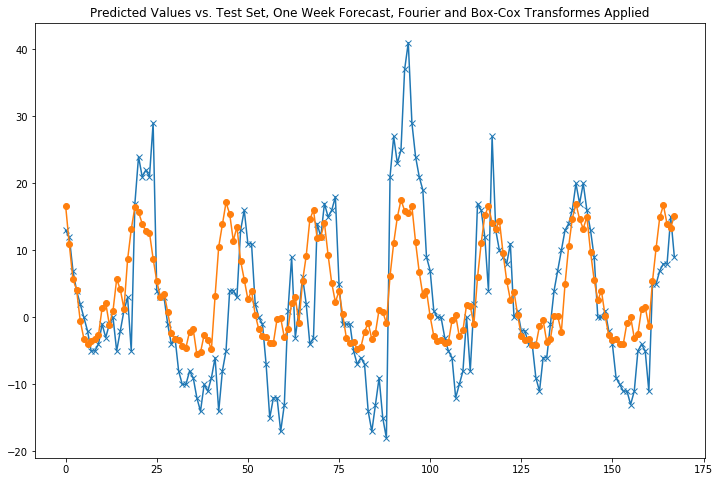

In [24]:
pipe2.fit(train)
print("Model fit:")
print(pipe2)

# We can compute predictions the same way we would on a normal ARIMA object:
preds, conf_int = pipe2.predict(n_periods=168, return_conf_int=True)
print("\nForecasts:")
print(preds)

print(f'RMSE: {RMSE(test[:168],preds)}')
print(f'RMSE 24 Hours: {RMSE(test[:168][:24], preds[:24])}')
print(f'SMAPE: {SMAPE(test[:168], preds)}')
print(f'SMAPE 24 hours: {SMAPE(test[:168][:24], preds[:24])}')
      

print(pipe2.summary())

# pipe.plot_diagnostics()

fig, ax = plt.subplots(figsize=(12,8))

x = np.arange(test[:168].shape[0])
ax.plot(x, test[:168], marker='x')
ax.plot(x, preds, marker='o')
ax.set_title('Predicted Values vs. Test Set, One Week Forecast, Fourier and Box-Cox Transformes Applied')

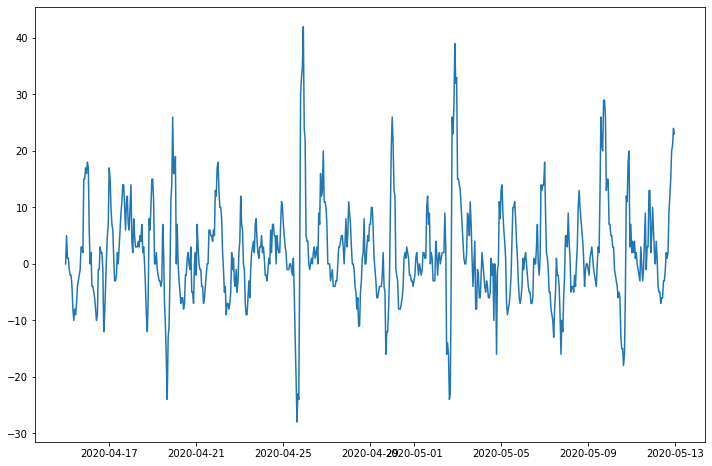

In [25]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train)